In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/horses-or-humans-dataset/horse-or-human/validation/humans/valhuman03-22.png
/kaggle/input/horses-or-humans-dataset/horse-or-human/validation/humans/valhuman02-05.png
/kaggle/input/horses-or-humans-dataset/horse-or-human/validation/humans/valhuman01-24.png
/kaggle/input/horses-or-humans-dataset/horse-or-human/validation/humans/valhuman05-26.png
/kaggle/input/horses-or-humans-dataset/horse-or-human/validation/humans/valhuman04-00.png
/kaggle/input/horses-or-humans-dataset/horse-or-human/validation/humans/valhuman02-00.png
/kaggle/input/horses-or-humans-dataset/horse-or-human/validation/humans/valhuman01-21.png
/kaggle/input/horses-or-humans-dataset/horse-or-human/validation/humans/valhuman04-18.png
/kaggle/input/horses-or-humans-dataset/horse-or-human/validation/humans/valhuman05-01.png
/kaggle/input/horses-or-humans-dataset/horse-or-human/validation/humans/valhuman01-12.png
/kaggle/input/horses-or-humans-dataset/horse-or-human/validation/humans/valhuman01-03.png
/kaggle/in

In [2]:
import os 
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import Model

In [3]:
# Define our example directories and files

train_dir = '../input/horses-or-humans-dataset/horse-or-human/train'
validation_dir = '../input/horses-or-humans-dataset/horse-or-human/validation'

train_horses_fnames = os.listdir('../input/horses-or-humans-dataset/horse-or-human/train/horses')
train_humans_fnames = os.listdir('../input/horses-or-humans-dataset/horse-or-human/train/humans')
validation_horses_fnames = os.listdir('../input/horses-or-humans-dataset/horse-or-human/validation/horses')
validation_humans_fnames = os.listdir('../input/horses-or-humans-dataset/horse-or-human/validation/humans')

In [4]:
print(len(train_horses_fnames))
print(len(train_humans_fnames))
print(len(validation_horses_fnames))
print(len(validation_humans_fnames))

500
527
128
128


In [5]:
# Download the inception v3 weights
!wget --no-check-certificate \
    https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5 \
    -O /tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5

--2021-06-13 11:37:19--  https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5
Resolving storage.googleapis.com (storage.googleapis.com)... 64.233.185.128, 74.125.21.128, 74.125.138.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|64.233.185.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 87910968 (84M) [application/x-hdf]
Saving to: ‘/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’

/tmp/inception_v3_w 100%[===================>]  83.84M  76.4MB/s    in 1.1s    

2021-06-13 11:37:20 (76.4 MB/s) - ‘/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’ saved [87910968/87910968]



In [6]:
#import the inception model 

from tensorflow.keras.applications.inception_v3 import InceptionV3
local_weights_file = '/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'

In [7]:
pre_trained_model=InceptionV3(
input_shape=(150,150,3),
include_top=False,
weights=None
)

pre_trained_model.load_weights(local_weights_file)

for layer in pre_trained_model.layers:
    layer.trainable=False 
    
pre_trained_model.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 74, 74, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 74, 74, 32)   96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 74, 74, 32)   0           batch_normalization[0][0]        
_______________________________________________________________________________________

In [8]:
last_layer=pre_trained_model.get_layer('mixed7')
print('last layer output shape :',last_layer.output_shape)

last_output=last_layer.output

last layer output shape : (None, 7, 7, 768)


In [17]:
# Define a Callback class that stops training once accuracy reaches 99.9%

class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self ,epochs ,logs={}):
        if(logs.get('accuracy')>0.999):
            print('\n Reached 99.9 % accuracy hence cancelling training ')
            self.model.stop_training = True

In [11]:
from tensorflow.keras.optimizers import RMSprop

x=layers.Flatten()(last_output)

x=layers.Dense(1024 ,activation='relu')(x)

#add a droprate

x=layers.Dropout(0.2)(x)

x=layers.Dense(1,activation='sigmoid')(x)

model=Model(pre_trained_model.input ,x)

model.compile(
optimizer=RMSprop(lr=0.0001),
loss='binary_crossentropy',
metrics=['accuracy'])

model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 74, 74, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 74, 74, 32)   96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 74, 74, 32)   0           batch_normalization[0][0]        
______________________________________________________________________________________________

In [13]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
# Add our data-augmentation parameters to ImageDataGenerator
train_datagen = ImageDataGenerator(
    rescale = 1./255.,
    rotation_range = 40,
    width_shift_range = 0.2,
    height_shift_range = 0.2,
    shear_range = 0.2,
    zoom_range = 0.2,
    horizontal_flip = True
)

# Note that the validation data should not be augmented!
test_datagen = ImageDataGenerator(
    rescale = 1./255.
)


# Flow training images in batches of 20 using train_datagen generator
train_generator = train_datagen.flow_from_directory(
    train_dir,
    batch_size=64,
    class_mode='binary',
    target_size=(150,150)
)     

# Flow validation images in batches of 20 using test_datagen generator
validation_generator =  test_datagen.flow_from_directory(
    validation_dir,
    batch_size=64,
    class_mode='binary',
    target_size=(150,150)
)

Found 1027 images belonging to 2 classes.
Found 256 images belonging to 2 classes.


In [18]:
callbacks=myCallback()

history = model.fit_generator(
    train_generator,
    epochs=50,
    validation_data=validation_generator,
    callbacks=[callbacks]
)

Epoch 1/50
17/17 [==============================] - 33s 2s/step - loss: 0.0484 - accuracy: 0.9844 - val_loss: 0.0062 - val_accuracy: 1.0000
Epoch 2/50
17/17 [==============================] - 33s 2s/step - loss: 0.0442 - accuracy: 0.9854 - val_loss: 0.0497 - val_accuracy: 0.9844
Epoch 3/50
17/17 [==============================] - 33s 2s/step - loss: 0.0120 - accuracy: 0.9971 - val_loss: 0.0016 - val_accuracy: 1.0000
Epoch 4/50
17/17 [==============================] - 32s 2s/step - loss: 0.0421 - accuracy: 0.9873 - val_loss: 0.0212 - val_accuracy: 0.9922
Epoch 5/50
17/17 [==============================] - 32s 2s/step - loss: 0.0096 - accuracy: 0.9961 - val_loss: 0.0141 - val_accuracy: 0.9922
Epoch 6/50
17/17 [==============================] - 33s 2s/step - loss: 0.0450 - accuracy: 0.9883 - val_loss: 0.0069 - val_accuracy: 0.9961
Epoch 7/50
17/17 [==============================] - 33s 2s/step - loss: 0.0155 - accuracy: 0.9942 - val_loss: 0.0115 - val_accuracy: 0.9961
Epoch 8/50
17/17 [==

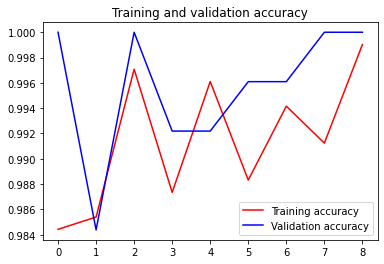

<Figure size 432x288 with 0 Axes>

In [21]:

import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()


plt.show()